#### Imports


In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import math
import random
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
import time
from scipy.optimize import curve_fit
from scipy.stats import norm

#### Functions

In [10]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    feature_cols = []
    for label in data.columns:
        if label[0] == "X" or label[0] == "Y":
            feature_cols.append(label)
        elif label[0] == "R":
            break
    

    label_cols = ["ResultPositionX", "ResultPositionY", "ResultDirectionX", "ResultDirectionY"]
    x = data[feature_cols]
    y = data[label_cols]
    return x, y

In [11]:
def adjust_x_y(x, y):
    width = 2*3.7/64

    y['ResultPositionX'] = (y['ResultPositionX'] + 3.7) - x['XStripID1'] * width
    y['ResultPositionY'] = (y['ResultPositionY'] + 3.7) - x['YStripID1'] * width

    adj_x = x.copy()
    cols = list(adj_x.columns[:len(x.columns) // 2])
    adj_x = adj_x.drop(cols, axis=1)

    # adj_y = y.copy()
    adj_y = pd.DataFrame()
    adj_y["ResultDistanceMag"] = (y["ResultPositionX"]**2 + y["ResultPositionY"]**2)**(1/2)
    adj_y["ResultDistanceDir"] = np.atan(y["ResultPositionY"], y["ResultPositionX"])
    directionMag = (y["ResultDirectionX"] ** 2 + y["ResultDirectionY"] ** 2)**(1/2)
    adj_y["ResultDirectionX"] = y["ResultDirectionX"] / directionMag
    adj_y["ResultDirectionY"] = y["ResultDirectionY"] / directionMag
    adj_y["ResultDirection"] = np.degrees(np.atan(y["ResultDirectionY"], y["ResultDirectionX"]))

    

    return adj_x, adj_y


In [21]:
def train_model(x_train, y_train, n_estimators=12, random_state=12345, verbose = 1):
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=random_state,
        verbosity=verbose
    )
    xgb.fit(
        x_train, y_train
    )
    return xgb


In [41]:
def test(rf, x_test, y_test):
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    direction2 = []
    
    for i in range(len(y_test)):
        dis_mag_t, dis_dir_t, dir_x_t, dir_y_t = y_test.iloc[i].iloc[0], y_test.iloc[i].iloc[1], y_test.iloc[i].iloc[2], y_test.iloc[i].iloc[3]
        dis_mag_p, dis_dir_p, dir_x_p, dir_y_p = y_pred[i][0], y_pred[i][1], y_pred[i][2], y_pred[i][3]
        dir_t= y_test.iloc[i].iloc[4]
        dir_p = y_pred[i][4]
        
        x_t = dis_mag_t * np.cos(dis_dir_t)
        y_t = dis_mag_t * np.sin(dis_dir_t)
        x_p = dis_mag_p * np.cos(dis_dir_p)
        y_p = dis_mag_p * np.sin(dis_dir_p)

        # error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        # error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        # distance.append(math.sqrt(error_x ** 2 + error_y**2))
        
        e_x = x_t - x_p
        e_y = y_t - y_p
        distance.append(math.sqrt(e_x**2 + e_y**2))
        direction2.append(abs(dir_p - dir_t))

        pred = np.array([dir_x_p, dir_y_p])
        real = np.array([dir_x_t, dir_y_t])
        cos_angle = np.dot(pred, real) / (np.linalg.norm(pred) * np.linalg.norm(real))
        direction.append(math.degrees(math.acos(np.clip(cos_angle, -1.0, 1.0))))

    return distance, direction, direction2

#### Run the Model (Call Functions)

In [37]:
# set up model
data = "output_x3_y2.csv"
print("Reading Data...")
x, y = read_data(data)
print("Adjusting Data...")
x, y = adjust_x_y(x, y)
print("Split Data...")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12345)
print("Done")

y

Reading Data...
Adjusting Data...
Split Data...
Done


,ResultDistanceMag,ResultDistanceDir,ResultDirectionX,ResultDirectionY,ResultDirection
0,0.080217,0.051594,-0.732580,0.680681,27.047948
1,0.093074,0.072269,0.920062,0.391772,19.282389
2,0.303264,0.118039,-0.972853,-0.231424,-12.732181
3,0.281598,0.146185,-0.329327,-0.944216,-43.314189
4,0.277700,0.028188,0.425953,0.904745,31.629331
...,...,...,...,...,...
15418,0.350039,0.089143,-0.373256,0.927728,4.020707
15419,0.364044,0.201757,-0.995363,0.096194,5.172318
15420,0.121798,0.121070,0.766663,-0.642049,-28.606726
15421,0.658366,0.461654,-0.181625,-0.983368,-44.370083


In [42]:
# run the model - normal
print("Training model...")
xgb = train_model(x_train, y_train, verbose = 2)
print("Validating model...")
distance, direction, direction2 = test(xgb, x_test, y_test)
print("Done")

Training model...


[12:16:16] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (10796, 5, 53980).


Validating model...
Done


#### Plots + Results

Average distance: 0.08237154498275483


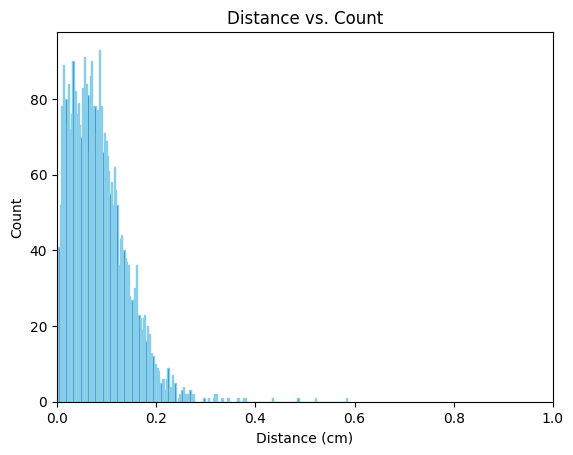

In [39]:
# Plots Distance vs Count

print("Average distance:", np.average(distance))
plt.hist(distance, bins=250, edgecolor='skyblue')
bottom, top = plt.ylim()
# plt.ylim(0, 10)
plt.xlim(0, 1)
plt.xlabel('Distance (cm)')
plt.ylabel('Count')
plt.title('Distance vs. Count')
plt.show()

Average direction (without adding negatives): 66.15761297491929
Standard devation (without adding negatives): 49.96530995561299


/tmp/ipykernel_38877/914263765.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(bin_centers, pdf_offset, 'r-', label=label, linewidth=2, linestyle='--')


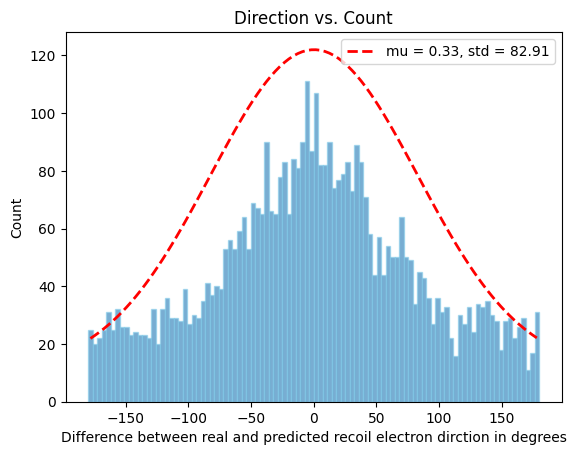

In [44]:
# Plots Direction vs Count
print("Average direction (without adding negatives):", np.average(direction))
print("Standard devation (without adding negatives):", np.std(direction))

r_direction = direction.copy()
for i in range(len(r_direction)):
    r_direction[i] *= random.choice([1, -1])


counts, bins, _ = plt.hist(r_direction, bins=100, edgecolor='skyblue', alpha=0.6)
mu, std = norm.fit(r_direction)

# 3. Compute bin centers and fitted curve
bin_centers = (bins[:-1] + bins[1:]) / 2
pdf = norm.pdf(bin_centers, mu, std)

# 4. Scale the PDF to match histogram height
pdf_scaled = pdf * max(counts) / max(pdf)

# 5. Optional: manually add an offset (e.g. estimated background level)
offset = min(counts)  # or pick a small constant
pdf_offset = pdf_scaled + offset

# 6. Plot the fit
label = f'mu = {round(mu, 2)}, std = {round(std, 2)}'
plt.plot(bin_centers, pdf_offset, 'r-', label=label, linewidth=2, linestyle='--')

plt.xlabel('Difference between real and predicted recoil electron dirction in degrees')
plt.ylabel('Count')
plt.title('Direction vs. Count')
plt.legend()
plt.show()

Average direction (2nd method) (without adding negatives): 21.839202968238975
Standard devation (2nd method) (without adding negatives): 12.718277034010766


/tmp/ipykernel_38877/2634670839.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(bin_centers, pdf_offset, 'r-', label=label, linewidth=2, linestyle='--')


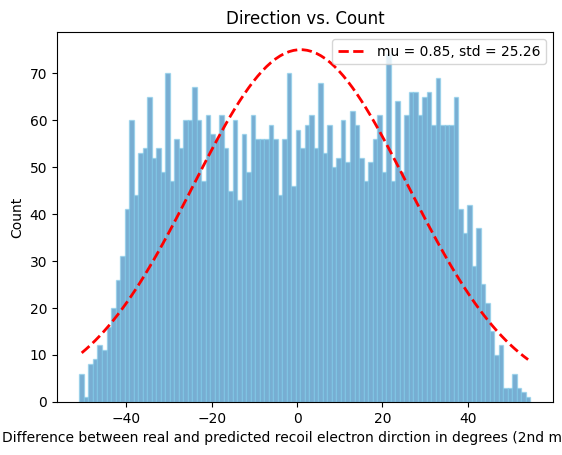

In [43]:
# Plots Direction vs Count
print("Average direction (2nd method) (without adding negatives):", np.average(direction2))
print("Standard devation (2nd method) (without adding negatives):", np.std(direction2))

r_direction = direction2.copy()
for i in range(len(r_direction)):
    r_direction[i] *= random.choice([1, -1])


counts, bins, _ = plt.hist(r_direction, bins=100, edgecolor='skyblue', alpha=0.6)
mu, std = norm.fit(r_direction)

# 3. Compute bin centers and fitted curve
bin_centers = (bins[:-1] + bins[1:]) / 2
pdf = norm.pdf(bin_centers, mu, std)

# 4. Scale the PDF to match histogram height
pdf_scaled = pdf * max(counts) / max(pdf)

# 5. Optional: manually add an offset (e.g. estimated background level)
offset = min(counts)  # or pick a small constant
pdf_offset = pdf_scaled + offset

# 6. Plot the fit
label = f'mu = {round(mu, 2)}, std = {round(std, 2)}'
plt.plot(bin_centers, pdf_offset, 'r-', label=label, linewidth=2, linestyle='--')

plt.xlabel('Difference between real and predicted recoil electron dirction in degrees (2nd method)')
plt.ylabel('Count')
plt.title('Direction vs. Count')
plt.legend()
plt.show()